In [1]:
import os
import json
import sys
import cv2
import numpy as np

In [17]:
root = '/checkpoint/apratik/finals/default/apartment_0/'

def make_data(root, img_indx):
    src_img = cv2.imread(os.path.join(root, "rgb/{:05d}.jpg".format(img_indx)))
    src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
    src_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx)))
    with open(os.path.join(root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]
    cur_pose = base_pose_data["{}".format(img_indx+5)]
    cur_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx+5)))
    cur_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx+5)))
    print(f'{type(src_img), type(src_depth), type(src_label)}')
    # Visualize label
    return src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cur_label
    
src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cur_label = make_data(root, 1)

hello_root = '/checkpoint/apratik/robot_trajectories/active/1/'
def get_hello_data(root, img_indx):
    src_img = cv2.imread(os.path.join(hello_root, f"rgb/{img_indx}.jpg"))
    src_depth = np.load(os.path.join(hello_root, f"depth/{img_indx}.npy"))
    src_label = np.load(os.path.join(hello_root, f"seg/{img_indx}.npy"))
    with open(os.path.join(hello_root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]['base_xyt']
    cam_transform = np.asarray(base_pose_data["{}".format(img_indx)]['cam_transform'])
    
    cur_pose = base_pose_data["{}".format(img_indx+5)]['base_xyt']
    cur_depth = np.load(os.path.join(hello_root, f"depth/{img_indx+5}.npy"))
    # cur_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx+5)))
    print(f'{type(src_img), type(src_depth), type(src_label)}')
    # Visualize label
    return src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cam_transform
    
src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cam_transform = get_hello_data(root, 100)


from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

from utils import d3_40_colors_rgb

def display_sample(src_img, semantic1, semantic2):
    
    arr = [src_img]
    for semantic_obs in [semantic1, semantic2]:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)

    titles = ['src_img', 'src', 'propagated']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

from droidlet.lowlevel.robot_mover_utils import transform_pose
from copy import deepcopy as copy
from numba import njit
import random
from math import floor, ceil

"""
1. Find pixel index for each label, keep the pts list pts_in_world
2. for each set, transform pts_in_world to current image frame
3. Do filteration - if norm(original pixel - current pixel) is greater than threshold, set it to false
4. Do quantization fix 

"""

import open3d as o3d

def compute_uvone_hello(height, width, cam_transform):
    # 640 / 480, so ppx and ppy are the center of the camera
    # realsense DEPTH_UNITS is 0.001, i.e. it's depth units are in mm
    fx, fy = 605.2880249, 605.65637207
    cx, cy = 319.11114502, 239.48382568
    intrinsic_mat = np.array([[  fx, 0., cx],
                              [  0., fy, cy],
                              [  0., 0., 1.]])
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_pixs = np.mgrid[0 : height : 1, 0 : width : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    extrinsic = cam_transform
    rot_cam = extrinsic[:3, :3]
    trans_cam = extrinsic[:3, 3]
    
    return uv_one_in_cam, intrinsic_mat, rot_cam, trans_cam

def compute_uvone(height, width):
    intrinsic_mat = np.array([[256, 0, 256], [0, 256, 256], [0, 0, 1]])
    rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
    trans = np.array([0, 0, 0.6])
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    return uv_one_in_cam, intrinsic_mat, rot, trans

def convert_depth_to_pcd(depth, pose, uv_one_in_cam, rot, trans):
    # point cloud in camera frame
    depth = (depth.astype(np.float32) / 1000.0).reshape(-1)
    pts_in_cam = np.multiply(uv_one_in_cam, depth)
    pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
    # point cloud in robot base frame
    pts_in_base = pts_in_cam[:3, :].T
    pts_in_base = np.dot(pts_in_base, rot.T)
    pts_in_base = pts_in_base + trans.reshape(-1)
    # point cloud in world frame (pyrobot)
    pts_in_world = transform_pose(pts_in_base, pose)
    return pts_in_world

@njit
def get_annot(height, width, pts_in_cur_img, src_label):
    annot_img = np.zeros((height, width))
    
    def get_row_col(x, h, w):
        # x = r*w + c
        r = int(x/w)
        c = int(x - r*w)
        return r, c
    
    for x in range(len(pts_in_cur_img)):
        r, c = get_row_col(x, height, width)
        x, y, _ = pts_in_cur_img[x]
        
        # Take ceil and floor combination to fix quantization errors
        if floor(x) >= 0 and ceil(x) < height and floor(y) >=0 and ceil(y) < width:
            annot_img[ceil(y)][ceil(x)] = src_label[r][c]
            annot_img[floor(y)][floor(x)] = src_label[r][c]
            annot_img[ceil(y)][floor(x)] = src_label[r][c]
            annot_img[floor(y)][ceil(x)] = src_label[r][c]
    
    return annot_img

def label_prop(
    src_img,
    src_depth,
    src_label,
    src_pose,
    base_pose,
    cur_depth,
):
    
    height, width, _ = src_img.shape
    uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width)
    
    pts_in_world = convert_depth_to_pcd(src_depth, src_pose, uv_one_in_cam, rot, trans)
    
    # TODO: use cur_pts_in_world for filtering. Not needed for baseline.
    # cur_pts_in_world = convert_depth_to_pcd(cur_depth, base_pose, uv_one_in_cam, rot, trans)
    
    # convert pts_in_world to current base
    pts_in_cur_base = transform_pose(pts_in_world, (-base_pose[0], -base_pose[1], 0))
    pts_in_cur_base = transform_pose(pts_in_cur_base, (0.0, 0.0, -base_pose[2]))

    # conver point from current base to current camera frame
    pts_in_cur_cam = pts_in_cur_base - trans.reshape(-1)
    pts_in_cur_cam = np.dot(pts_in_cur_cam, rot)

    # conver pts in current camera frame into 2D pix values
    pts_in_cur_img = np.matmul(intrinsic_mat, pts_in_cur_cam.T).T
    pts_in_cur_img /= pts_in_cur_img[:, 2].reshape([-1, 1])
    
    return get_annot(height, width, pts_in_cur_img, src_label)


(<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
(<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)


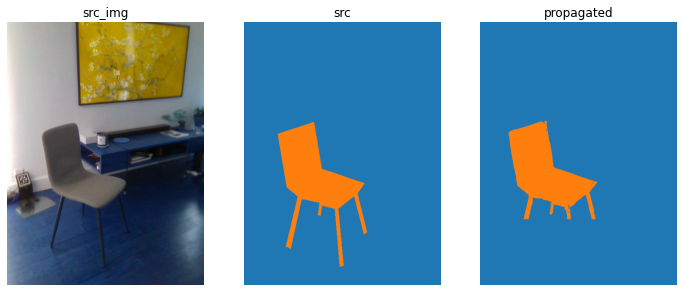

In [18]:
import time

nstart = time.time()
label = label_prop(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cam_transform)

nend = time.time()
display_sample(src_img, src_label, label)

# ostart = time.time()
# label = label_prop_old(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
# oend = time.time()

# display_sample(src_img, src_label, label)

# print(f'new time {nend-nstart}')
# print(f'old time {oend-ostart}')



In [28]:
# write a fn that takes in a GT frame, prop length and propagates

def visualize(images, height, width):
    color_dict = {}
    
    for filename, image, masks in images:
        image = image.astype(np.uint8)
        # print(np.unique(masks))

        for x in np.unique(masks):
            if x > 0:
                binary_mask = (masks == x).astype(np.uint8)
                # print(binary_mask.shape, np.unique(binary_mask))
                # print(image.shape, binary_mask.shape)
                
                if x not in color_dict.keys():
                    color = list(np.random.choice(range(256), size=3))
                    color_dict[x] = color
                    
                color = color_dict[x]
                image[binary_mask == 1] = color
                # image = cv2.bitwise_or(image, image, binary_mask)
        
        cv2.imwrite('prop2/{:05d}.jpg'.format(filename), image) 
        # plt.imshow(image)
        # plt.show()
        

def run_label_prop(traj_dir, gt_frame_id, prop_length, read_fn):
    src_img, src_label, src_depth, src_pose, cam_transform = read_fn(traj_dir, gt_frame_id)
    height, width, _ = src_img.shape
    propagated = []
    
    for x in range(gt_frame_id-prop_length, gt_frame_id+prop_length+1):
        cur_img, _, cur_depth, cur_pose, cam_transform = read_fn(traj_dir, x)
        cur_label = label_prop(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cam_transform)
        propagated.append((x, cur_img, cur_label))
        
    visualize(propagated, height, width)
        

def read_habitat_data(root, img_indx):
    src_img = cv2.imread(os.path.join(root, "rgb/{:05d}.jpg".format(img_indx)))
    src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
    src_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx)))
    with open(os.path.join(root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]
    
    # Visualize label
    return src_img, src_label, src_depth, src_pose
    
def read_hello_data(root, img_indx):
    src_img = cv2.imread(os.path.join(hello_root, f"rgb/{img_indx}.jpg"))
    src_depth = np.load(os.path.join(hello_root, f"depth/{img_indx}.npy"))
    src_label = None
    if os.path.isfile(os.path.join(hello_root, f"seg/{img_indx}.npy")):
        src_label = np.load(os.path.join(hello_root, f"seg/{img_indx}.npy"))
    with open(os.path.join(hello_root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]['base_xyt']
    cam_transform = np.asarray(base_pose_data["{}".format(img_indx)]['cam_transform'])
    return src_img, src_label, src_depth, src_pose, cam_transform

In [29]:
# start = time.time()
# run_label_prop('/checkpoint/apratik/finals/default/apartment_0/', 100, 50, read_habitat_data)
# end = time.time()
# print(f'new impl {end-start}')

In [30]:
# start = time.time()
# run_label_prop('/checkpoint/apratik/finals/default/apartment_0/', 100, 50, read_habitat_data)
# end = time.time()
# print(f'new impl {end-start}')

run_label_prop('/checkpoint/apratik/robot_trajectories/active/1/', 100, 50, read_hello_data)

intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsic_mat.shape (3, 3) rot.shape (3, 3), trans.shape (3,)
intrinsi

In [20]:
"""
high level overview

input
src_img,
src_depth,
src_label,
src_pose,
base_pose,
cur_depth,


take sdepth + spose -> spts in world
for each label, take lpts and transform it to cur_base -> cur_cam 


"""

'\nhigh level overview\n\ninput\nsrc_img,\nsrc_depth,\nsrc_label,\nsrc_pose,\nbase_pose,\ncur_depth,\n\n\ntake sdepth + spose -> spts in world\nfor each label, take lpts and transform it to cur_base -> cur_cam \n\n\n'